In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils2 import *
# from georeg import *

import random
import cameratransform as ct
from rasterio.merge import merge

In [2]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#project_path = os.path.join('../../../', 'lake_dataset')
# project_path = os.path.join('../../../', 'estuarine_dataset')
project_path = 'gulf_stream_dataset/'

project_path

'gulf_stream_dataset/'

Here we'll show the master function that simply needs a directory set up as:

And it will process it all the way from raw imagery to Rrs.

### Raw -> Lt -> Lw (Mobley method) -> Rrs (Panel) w/o pixel masking

In [4]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_mobley', output_csv_path=project_path, lw_method='mobley_rho_method', 
                   mask_pixels=False, ed_method='panel_ed', overwrite=False, clean_intermediates=False)

Processing a total of 96 captures or 19 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: gulf_stream_dataset//raw_water_imgs
Loading ImageSet from: gulf_stream_dataset/align_img
used warp dir gulf_stream_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2


/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:00.000398
Alignment+Saving rate: 40201.01 images per second
Finished saving images.
Finished saving image metadata.
Converting raw sky images to radiance (raw sky -> Lsky).
Loading ImageSet from: gulf_stream_dataset//raw_sky_imgs
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3


/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:00.003958
Alignment+Saving rate: 1263.26 images per second
Finished saving images.
Finished saving image metadata.
Applying the mobley_rho_method (Lt -> Lw).
Normalizing by panel irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: gulf_stream_dataset/panel
All data has been saved as Rrs using the mobley_rho_method to calcualte Lw and normalized by panel_ed irradiance.
Not masking pixels.


True

In [8]:
rrs_imgs_mobley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_mobley')

In [9]:
def format_alta_logs(fp):
    alta_logs = pd.read_csv(fp)
    # the last few hundred lines don't follow csv rules and are just summary data
    alta_logs.drop(alta_logs.tail(250).index,inplace=True)
    # this may introduce a tiny bit of error but I do this so I have a unique index for matching time
    # TODO could instead resample to seconds and take a mean
    alta_logs['id'] = alta_logs.index
    alta_logs['dt'] = pd.to_datetime(alta_logs.Date.apply(str)+alta_logs['GPS Time']+'.'+alta_logs.id.apply(str).str.zfill(9).apply(str).str.slice(start=3,stop=9), format='%Y%m%d%H:%M:%S.%f')
    alta_logs = alta_logs.set_index('dt')
    alta_logs = alta_logs.sort_index()
    return(alta_logs)

In [10]:
alta_logs = format_alta_logs(project_path + '/SYNLog-13-39-33_27-08-2021_edit.csv')
alta_logs.head()

Reading  IMU Time      Date  GPS Time  Unnamed: 4  \
dt                                                                              
2021-08-27 13:39:34.000000       46     1.766  20210827  13:39:34         NaN   
2021-08-27 13:39:34.000001       47     1.806  20210827  13:39:34         NaN   
2021-08-27 13:39:34.000002       48     1.846  20210827  13:39:34         NaN   
2021-08-27 13:39:34.000003       49     1.886  20210827  13:39:34         NaN   
2021-08-27 13:39:34.000004       50     1.926  20210827  13:39:34         NaN   

                            Longitude   Latitude  GPS Height  GPS Course  \
dt                                                                         
2021-08-27 13:39:34.000000 -747154560  356808608        2.92         4.3   
2021-08-27 13:39:34.000001 -747154560  356808608        2.92         4.3   
2021-08-27 13:39:34.000002 -747154560  356808608        2.92         4.3   
2021-08-27 13:39:34.000003 -747154560  356808608        2.92         4.3   
2021-08-27 13:39:34.000004 -747154496  356808608        2.91         4.2   

                            GPS Pos N  ...  Gyro Bias P  Gyro Bias Y  \
dt                                     ...                             
2021-08-27 13:39:34.000000     183.02  ...     -37.2736       8.8494   
2021-08-27 13:39:34.000001     183.02  ...     -37.2708       8.8476   
2021-08-27 13:39:34.000002     183.02  ...     -37.2703       8.8488   
2021-08-27 13:39:34.000003     183.02  ...     -37.2672       8.8489   
2021-08-27 13:39:34.000004     183.02  ...     -37.2624       8.8453   

                            Accel Bias X  Accel Bias Y  Accel Bias Z  \
dt                                                                     
2021-08-27 13:39:34.000000         0.148         0.135         0.237   
2021-08-27 13:39:34.000001         0.149         0.136         0.237   
2021-08-27 13:39:34.000002         0.150         0.137         0.237   
2021-08-27 13:39:34.000003         0.151         0.137         0.237   
2021-08-27 13:39:34.000004         0.153         0.138         0.236   

                            Extended Status  5V Alarm  Z Vibration  Checksum  \
dt                                                                             
2021-08-27 13:39:34.000000                0         0         0.07        23   
2021-08-27 13:39:34.000001                0         0         0.07       118   
2021-08-27 13:39:34.000002                0         0         0.07        37   
2021-08-27 13:39:34.000003                0         0         0.07       131   
2021-08-27 13:39:34.000004                0         0         0.07       190   

                            id  
dt                              
2021-08-27 13:39:34.000000   0  
2021-08-27 13:39:34.000001   1  
2021-08-27 13:39:34.000002   2  
2021-08-27 13:39:34.000003   3  
2021-08-27 13:39:34.000004   4  

[5 rows x 174 columns]

In [18]:
row['UTC-Time']

Timestamp('2021-08-27 13:40:21')

In [26]:
alta_yaws = []
for index, row in rrs_img_metadata.iterrows(): # yes I know this is an anti-pattern
    # utc_time = datetime.datetime.strptime(row['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(row['UTC-Time'], method='nearest')
    alta_yaws.append((alta_logs.iloc[img_idx]['Yaw'] + 360) % 360)

In [30]:
rrs_img_metadata['alta_yaw'] = alta_yaws
rrs_img_metadata['micasense_yaw'] = (rrs_img_metadata['    GPSImgDirection'] + 360) % 360

In [29]:
258.1 - 360

-101.89999999999998

Micasense Yaw: 275.1957995456921
Alta Yaw: 258.1
Pitch: 22.948717808368993


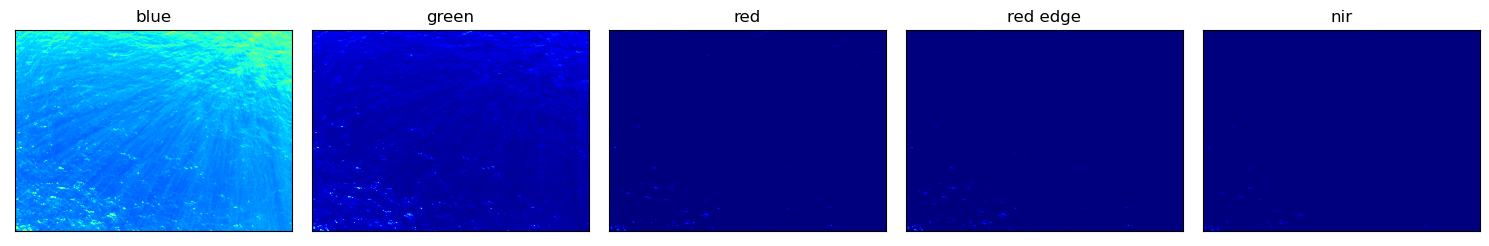

Micasense Yaw: 274.92874645340464
Alta Yaw: 258.0
Pitch: 23.178898586801978


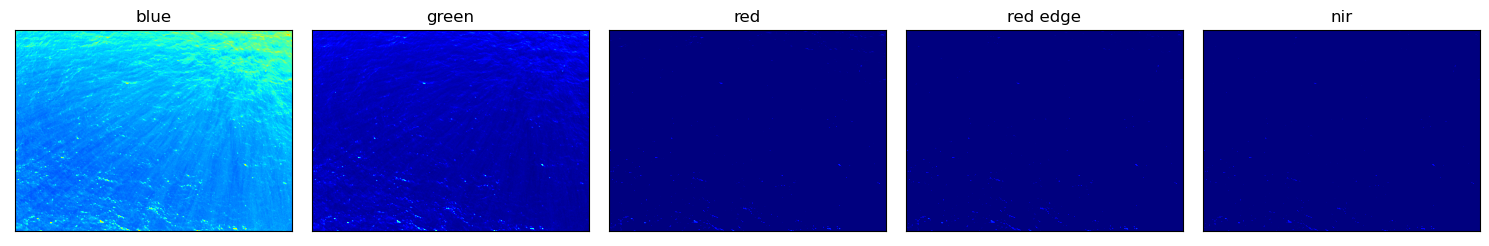

Micasense Yaw: 274.9092913588688
Alta Yaw: 258.2
Pitch: 23.00685978522143


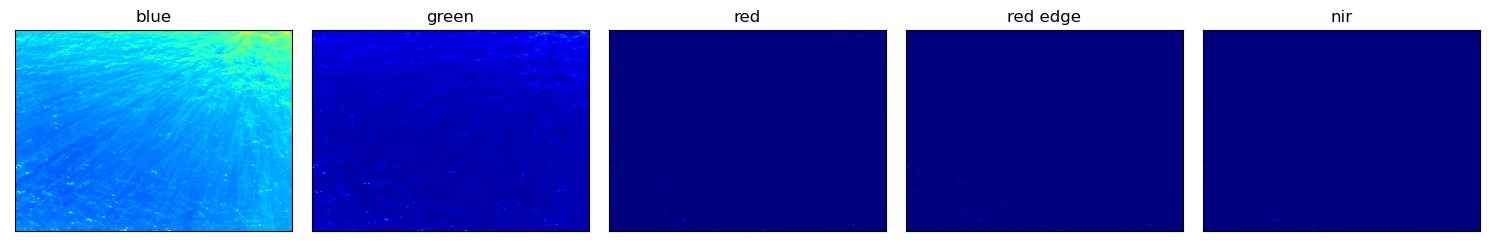

Micasense Yaw: 271.3954598442969
Alta Yaw: 258.0
Pitch: 22.624508523879108


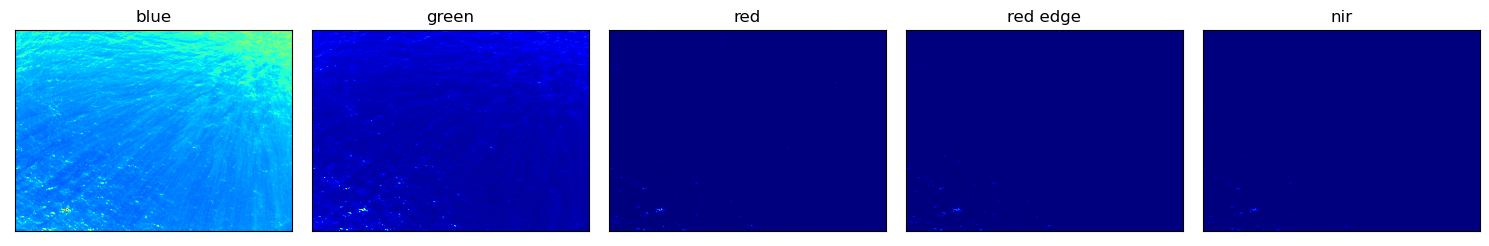

Micasense Yaw: 265.4955105202415
Alta Yaw: 256.3
Pitch: 22.85046004889679


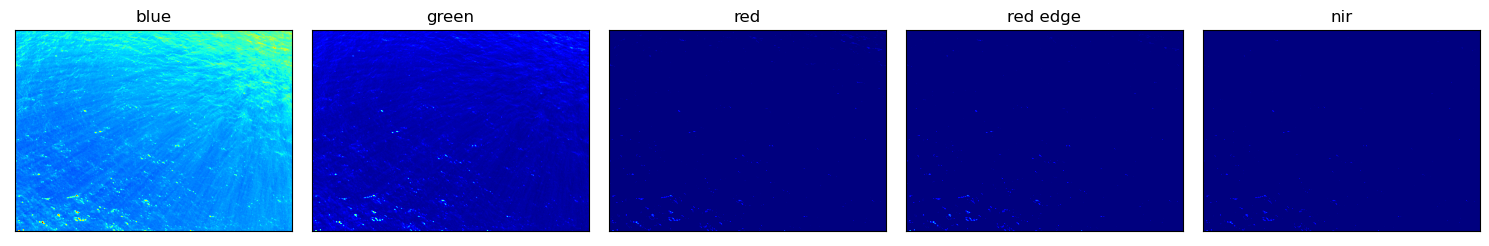

Micasense Yaw: 265.24574915585333
Alta Yaw: 251.2
Pitch: 22.80066699347175


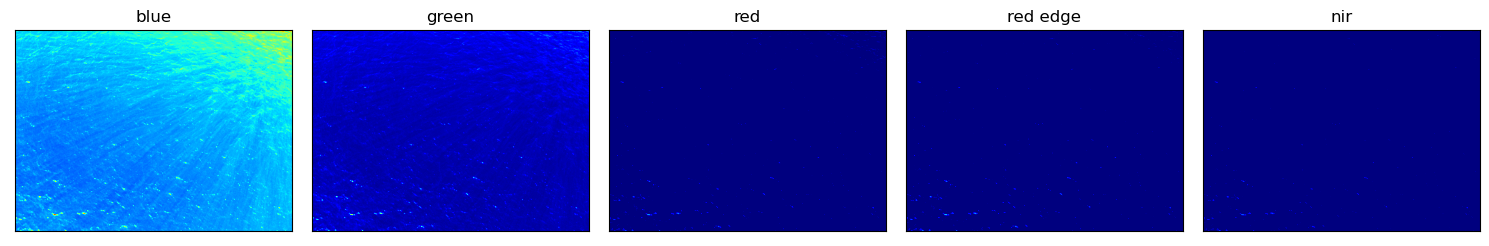

Micasense Yaw: 261.1940297023899
Alta Yaw: 249.0
Pitch: 23.468172285789624


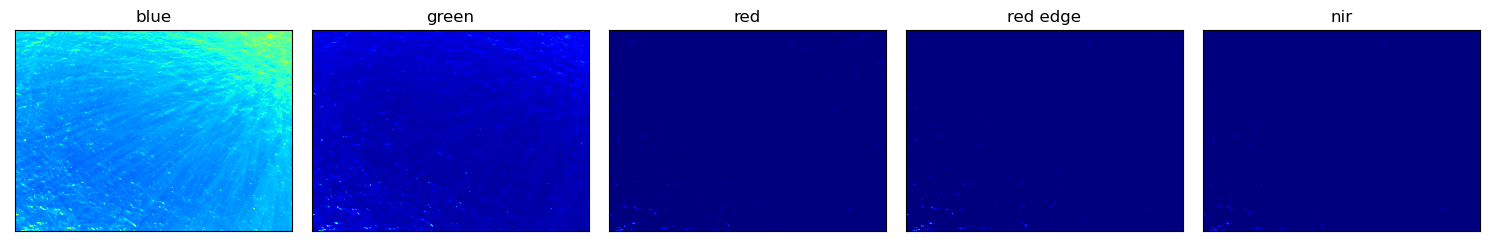

Micasense Yaw: 246.02127218001914
Alta Yaw: 247.2
Pitch: 22.231297235457205


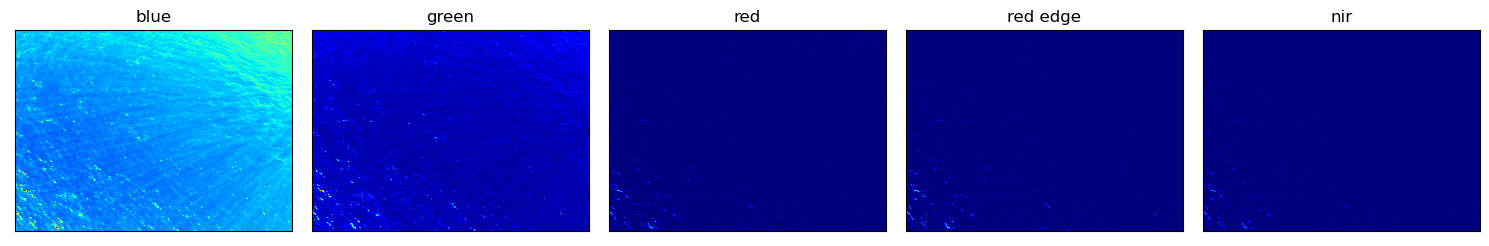

Micasense Yaw: 235.24598467525988
Alta Yaw: 235.0
Pitch: 22.34487044883527


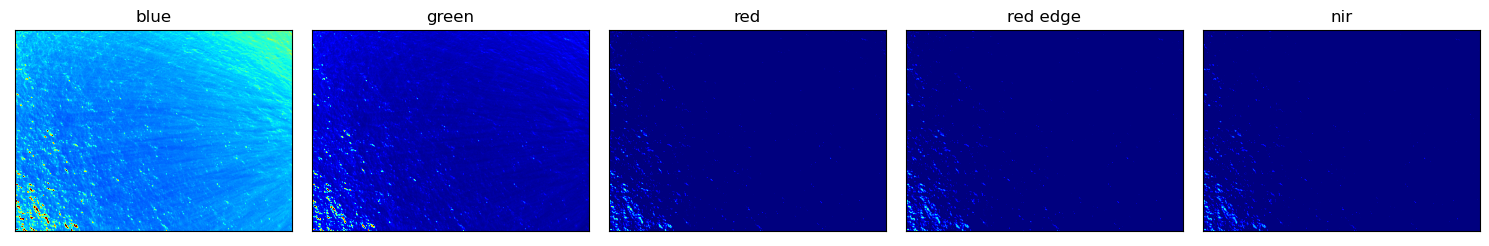

Micasense Yaw: 233.50554463334754
Alta Yaw: 222.6
Pitch: 22.817620826382786


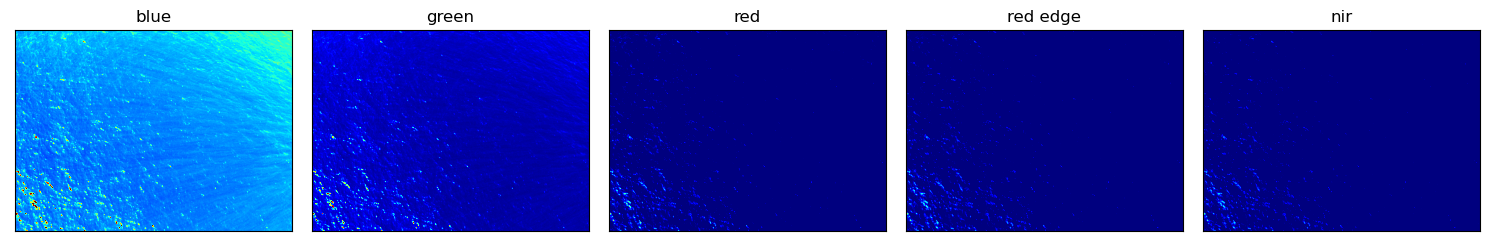

Micasense Yaw: 231.7737944280766
Alta Yaw: 217.9
Pitch: 22.67085343162435


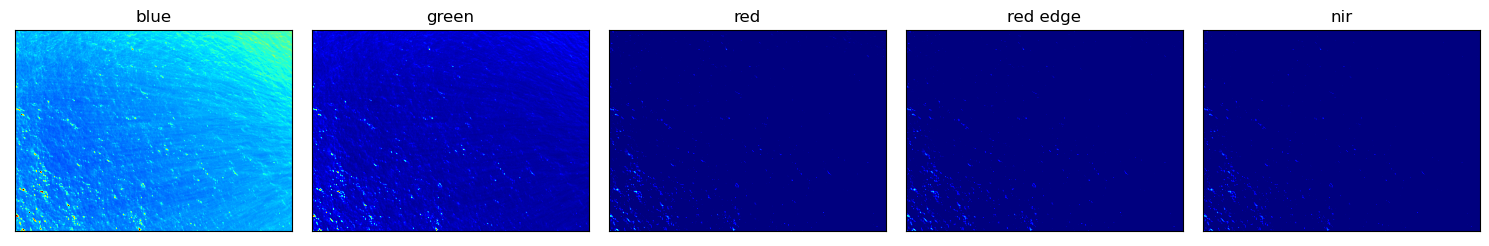

Micasense Yaw: 230.774268862779
Alta Yaw: 219.7
Pitch: 22.290838639012527


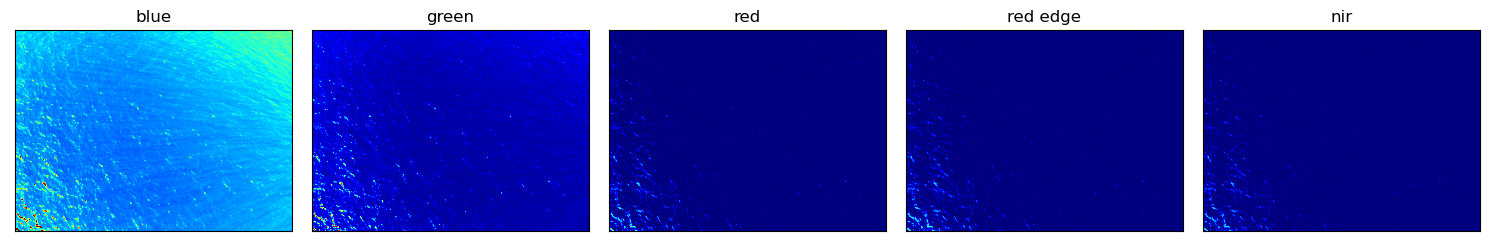

Micasense Yaw: 230.12679054778877
Alta Yaw: 219.6
Pitch: 22.271569030103453


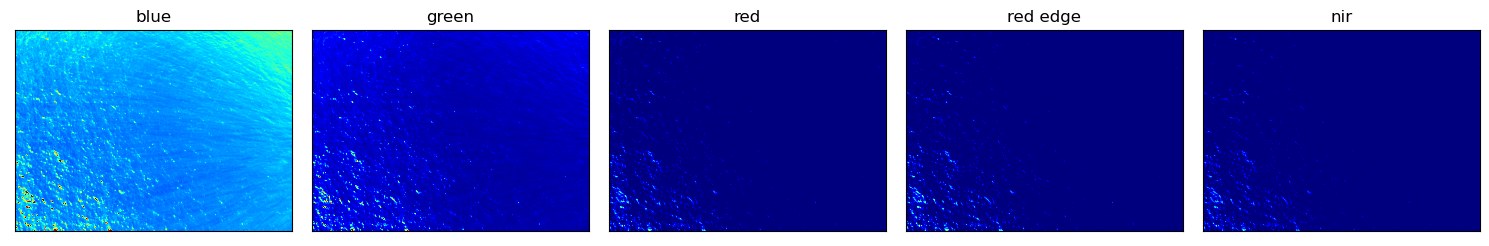

Micasense Yaw: 229.6997647166149
Alta Yaw: 219.8
Pitch: 22.08120880301484


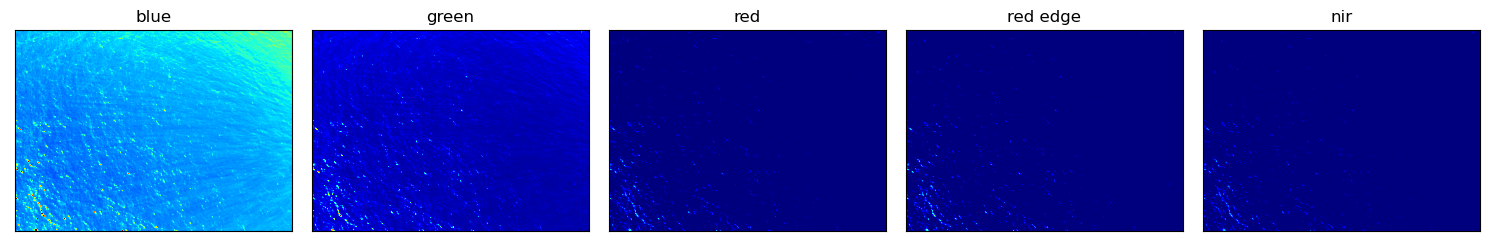

Micasense Yaw: 228.98119545663036
Alta Yaw: 219.7
Pitch: 22.225421710434567


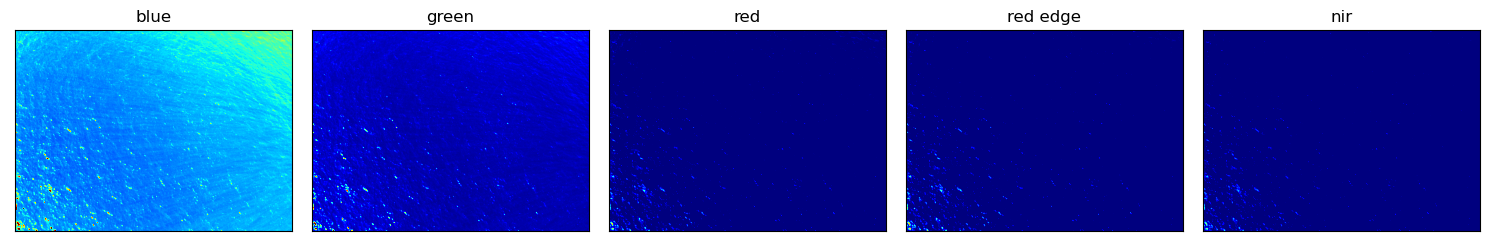

Micasense Yaw: 228.26228832621192
Alta Yaw: 219.6
Pitch: 23.00255987414443


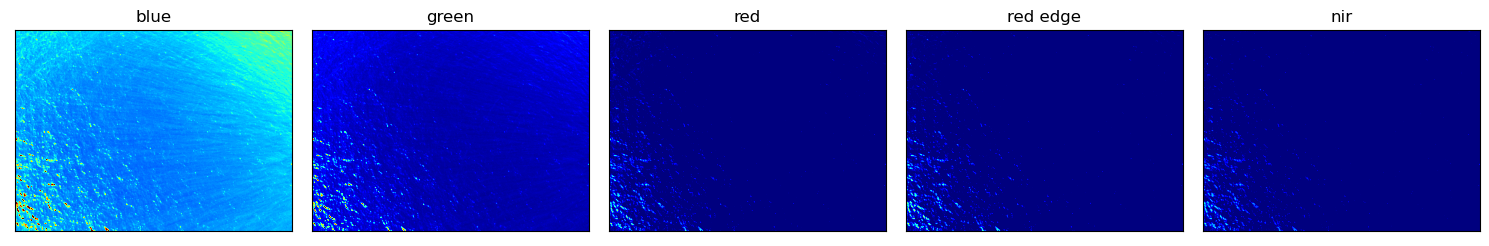

In [33]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_mobley)):
    print('Micasense Yaw: '+ str(rrs_img_metadata['micasense_yaw'][j]))
    print('Alta Yaw: '+ str(rrs_img_metadata['alta_yaw'][j]))
    print('Pitch: '+ str(rrs_img_metadata['GPSPitch'][j]+30))
    fig, ax = plt.subplots(1,5, figsize=(15,4))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_mobley[j,i],cmap='jet', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
        # cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        # cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

### Raw -> Lt -> Lw (Black pixel method) -> Rrs (DLS) w/o pixel masking

In [5]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_blackpixel', output_csv_path=project_path, lw_method='blackpixel_method', 
                   mask_pixels=False, ed_method='dls_ed', overwrite=True, clean_intermediates=False)


Processing a total of 80 captures or 16 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: estuarine_dataset//raw_water_imgs
Loading ImageSet from: estuarine_dataset/align_img
used warp dir estuarine_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Finished aligning band 2


/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:17.436078
Alignment+Saving rate: 0.92 images per second
Finished saving images.
Finished saving image metadata.
Converting raw sky images to radiance (raw sky -> Lsky).
Loading ImageSet from: estuarine_dataset//raw_sky_imgs
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3


/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/clifgray/Code/working/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:01.890194
Alignment+Saving rate: 1.06 images per second
Finished saving images.
Finished saving image metadata.
Applying the blackpixel_method (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: estuarine_dataset/raw_water_imgs
All data has been saved as Rrs using the blackpixel_method to calcualte Lw and normalized by dls_ed irradiance.
Not masking pixels.


True

Now visualize the output

### Raw -> Lt -> Lw (Hedley method) -> Rrs (DLS) w/o pixel masking

In [16]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', random_n=15,
                   mask_pixels=False,ed_method='dls_ed', overwrite=False, clean_intermediates=False)


Processing a total of 80 captures or 16 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: ../../../estuarine_dataset/raw_water_imgs
Loading ImageSet from: ../../../estuarine_dataset/align_img
used warp dir ../../../estuarine_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 1
Finished aligning band 4
Finished aligning band 2


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:00.013660
Alignment+Saving rate: 1171.30 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: ../../../estuarine_dataset/raw_water_imgs
All data has been saved as Rrs using the hedley_method to calcualte Lw and normalized by dls_ed irradiance.
Not masking pixels.


True

### Raw -> Lt -> Lw (Hedley method) -> Rrs (panel) 
#### running without overwriting previous data in order to get panel Ed

In [17]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', random_n=15,
                   mask_pixels=False, ed_method='panel_ed', overwrite=False, clean_intermediates=False)


Processing a total of 80 captures or 16 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: ../../../estuarine_dataset/raw_water_imgs
Loading ImageSet from: ../../../estuarine_dataset/align_img
used warp dir ../../../estuarine_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 1
Finished aligning band 4


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:00.017132
Alignment+Saving rate: 933.92 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by panel irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: ../../../estuarine_dataset/panel
All data has been saved as Rrs using the hedley_method to calcualte Lw and normalized by panel_ed irradiance.
Not masking pixels.


True

### Take a look at Rrs images to determine pixel masking

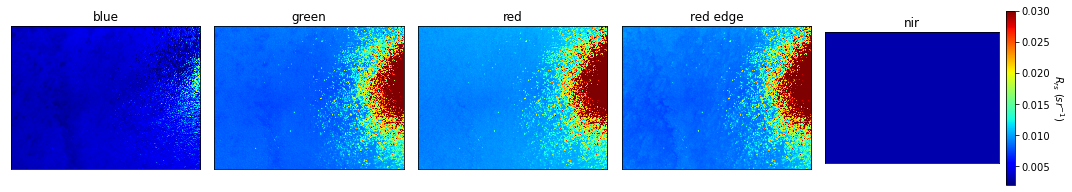

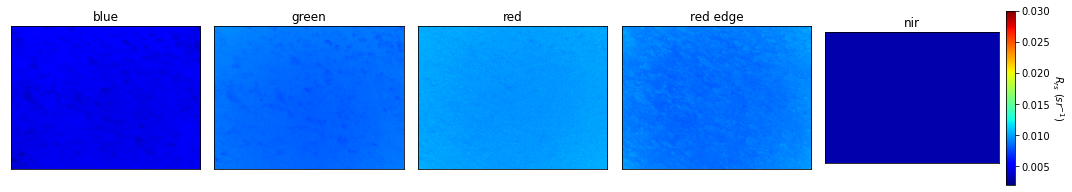

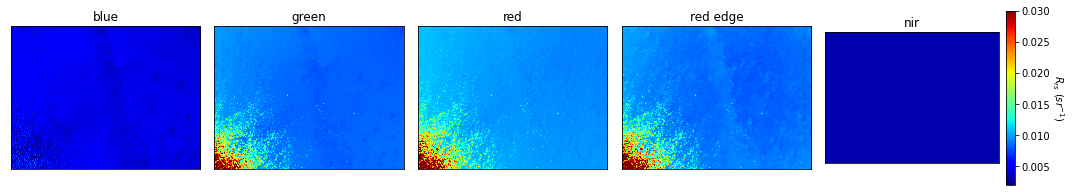

In [20]:
rrs_imgs_hedley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley')

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in random.sample(list(range(len(rrs_imgs_hedley))), 3): #chose random number of images to plot
    fig, ax = plt.subplots(1,5, figsize=(15,4))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i],cmap='jet', vmin=0.002, vmax=0.03)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[4], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 

### Raw -> Lt -> Lw (Black pixel method) -> Rrs (DLS) w/ pixel masking (using thresholds)

In [25]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', 
                   mask_pixels=True, pixel_masking_method='value_threshold', nir_threshold=0.01, green_threshold=0.005,
                   ed_method='dls_ed', overwrite=False, clean_intermediates=False)


Processing a total of 80 captures or 16 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: ../../../estuarine_dataset/raw_water_imgs
Loading ImageSet from: ../../../estuarine_dataset/align_img
used warp dir ../../../estuarine_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3


/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/imageprocessing/Final/FINAL/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:00.019370
Alignment+Saving rate: 826.02 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: ../../../estuarine_dataset/raw_water_imgs
All data has been saved as Rrs using the hedley_method to calcualte Lw and normalized by dls_ed irradiance.
Masking pixels using NIR and green Rrs thresholds


True

### Read in data

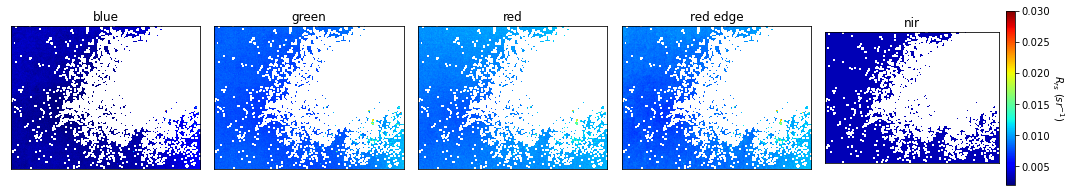

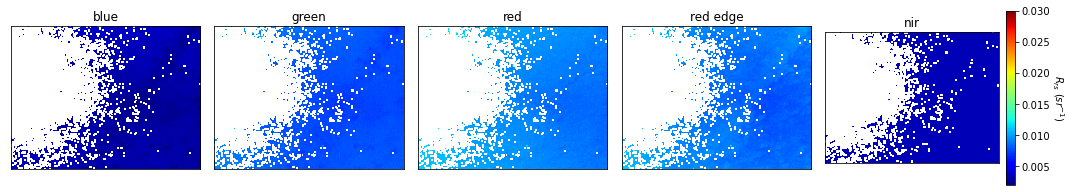

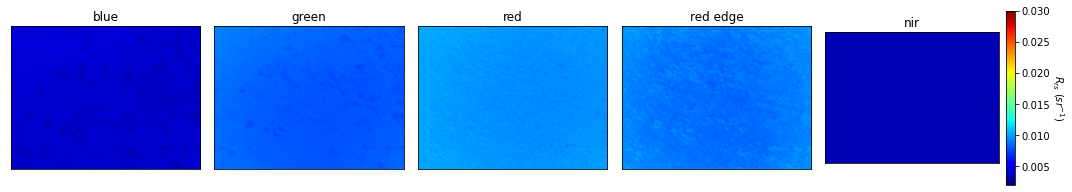

In [26]:
masked_rrs_imgs_hedley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in random.sample(list(range(len(masked_rrs_imgs_hedley))), 3): #chose random number of images to plot
    fig, ax = plt.subplots(1,5, figsize=(15,4))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='jet', vmin=0.002, vmax=0.03)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[4], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 

In [9]:
lt_imgs, lt_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')
lsky_imgs, lsky_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs', sky=True)

lw_imgs, lw_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lw_imgs')

dls_ed = pd.read_csv(project_path+'/dls_ed.csv') 
# panel_ed = pd.read_csv(project_path+'/panel_ed.csv') 

rrs_imgs_blackpixel, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_blackpixel')
# rrs_imgs_mobley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_mobley')
# rrs_imgs_hedley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley')
# masked_rrs_imgs_hedley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')


### View metadata 
#### Metadata is the same for each processed dataset

In [10]:
lt_img_metadata.head()

SourceFile     GPSDateStamp  \
filename                                                          
capture_1.tif  estuarine_dataset/capture_1.tif       2020:10:01   
capture_2.tif  estuarine_dataset/capture_2.tif       2020:10:01   
capture_3.tif  estuarine_dataset/capture_3.tif       2020:10:01   
capture_4.tif  estuarine_dataset/capture_4.tif       2020:10:01   
capture_5.tif  estuarine_dataset/capture_5.tif       2020:10:01   

                  GPSTimeStamp      GPSLatitude     GPSLatitudeRef  \
filename                                                             
capture_1.tif         16:02:35        38.696491                  N   
capture_2.tif         16:02:37        38.696613                  N   
capture_3.tif         16:02:39        38.696701                  N   
capture_4.tif         16:02:41        38.696770                  N   
capture_5.tif         16:02:43        38.696848                  N   

                   GPSLongitude     GPSLongitudeRef      GPSAltitude  \
filename                                                               
capture_1.tif        -75.980171                   W           86.475   
capture_2.tif        -75.980126                   W           85.809   
capture_3.tif        -75.980083                   W           85.449   
capture_4.tif        -75.980051                   W           85.274   
capture_5.tif        -75.980018                   W           85.312   

                   FocalLength      ImageWidth  ImageHeight  \
filename                                                      
capture_1.tif          5.43432            1280          960   
capture_2.tif          5.43432            1280          960   
capture_3.tif          5.43432            1280          960   
capture_4.tif          5.43432            1280          960   
capture_5.tif          5.43432            1280          960   

                   GPSImgDirection   GPSPitch    GPSRoll            UTC-Time  
filename                                                                      
capture_1.tif           -80.106253  -9.188963  10.370811 2022-12-16 16:02:35  
capture_2.tif           -82.177910  -9.127214  -1.462324 2022-12-16 16:02:37  
capture_3.tif           -82.925024 -10.330954   5.292332 2022-12-16 16:02:39  
capture_4.tif           -83.344727  -8.729560   3.584024 2022-12-16 16:02:41  
capture_5.tif           -83.760578  -6.986038   5.224941 2022-12-16 16:02:43

### Plot altitude and lat, lon

Text(0.5, 0, 'Longitude')

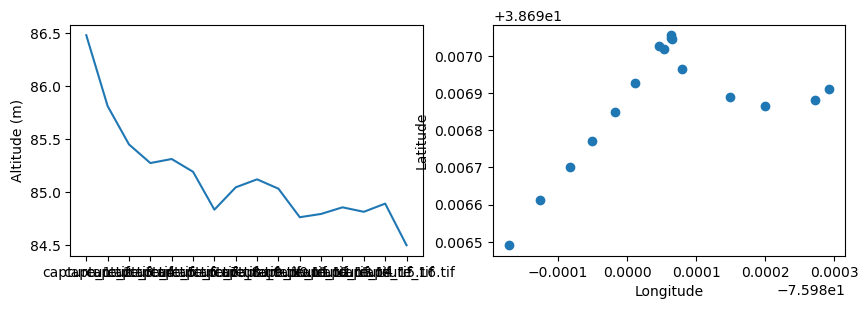

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(lt_img_metadata['    GPSAltitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(lt_img_metadata['    GPSLongitude'], lt_img_metadata['    GPSLatitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

### Plot all spectra

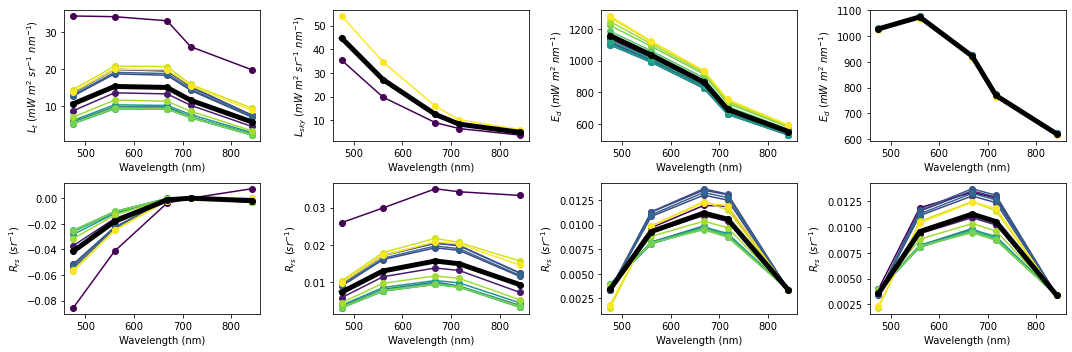

In [31]:
fig, ax = plt.subplots(2,4, figsize=(15,5))

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

#lt
for i in range(len(lt_imgs)):
    ax[0,0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[0,0].set_xlabel('Wavelength (nm)')
    ax[0,0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
ax[0,0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#lsky
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    ax[0,1].plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2))*1000,  marker = 'o', color=colors[i], label="")
    ax[0,1].set_xlabel('Wavelength (nm)')
    ax[0,1].set_ylabel('$L_{sky}\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')    
ax[0,1].plot(wv, np.nanmean(lsky_imgs[:,0:5,:,:], axis=(0,2,3))*1000,  marker = 'o', color='black', linewidth=5, label='Average')

#dls ed
ed = pd.read_csv(project_path+'/dls_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    ax[0,2].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) #multiply by 1000 to convert to mW
    ax[0,2].set_xlabel('Wavelength (nm)')
    ax[0,2].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
ax[0,2].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Average')

#panel ed
ed = pd.read_csv(project_path+'/panel_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    ax[0,3].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) #multiply by 1000 to convert to mW
    ax[0,3].set_xlabel('Wavelength (nm)')
    ax[0,3].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
ax[0,3].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Average')


#rrs_imgs_blackpixel
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_blackpixel)))

for i in range(len(rrs_imgs_blackpixel)):
    ax[1,0].plot(wv, np.nanmean(rrs_imgs_blackpixel[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[1,0].set_xlabel('Wavelength (nm)')
    ax[1,0].set_ylabel('$R_{rs}\ (sr^{-1}$)')   
ax[1,0].plot(wv, np.nanmean(rrs_imgs_blackpixel[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs_imgs_mobley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_mobley)))

for i in range(len(rrs_imgs_mobley)):
    ax[1,1].plot(wv, np.nanmean(rrs_imgs_mobley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[1,1].set_xlabel('Wavelength (nm)')
    ax[1,1].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
    
ax[1,1].plot(wv, np.nanmean(rrs_imgs_mobley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs_imgs_hedley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_hedley)))

for i in range(len(rrs_imgs_hedley)):
    ax[1,2].plot(wv, np.nanmean(rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[1,2].set_xlabel('Wavelength (nm)')
    ax[1,2].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
    
ax[1,2].plot(wv, np.nanmean(rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs_imgs_hedley_masked
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    ax[1,3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    ax[1,3].set_xlabel('Wavelength (nm)')
    ax[1,3].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
    
ax[1,3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

fig.tight_layout() 

### Save mean Rrs for each image in dataframe

In [32]:
rrs_blue = []
rrs_green = []
rrs_red = []
rrs_rededge = []
rrs_nir= []

for i in range(len(masked_rrs_imgs_hedley)):
    rrs_blue.append(np.nanmean(masked_rrs_imgs_hedley[i,0,:,:]))
    rrs_green.append(np.nanmean(masked_rrs_imgs_hedley[i,1,:,:]))
    rrs_red.append(np.nanmean(masked_rrs_imgs_hedley[i,2,:,:]))
    rrs_rededge.append(np.nanmean(masked_rrs_imgs_hedley[i,3,:,:]))
    rrs_nir.append(np.nanmean(masked_rrs_imgs_hedley[i,4,:,:]))
    
df = rrs_img_metadata[['SourceFile', '    GPSLatitude', '    GPSLongitude']]
df['rrs_blue'] = rrs_blue
df['rrs_green'] = rrs_green
df['rrs_red'] = rrs_red
df['rrs_rededge'] = rrs_rededge
df['rrs_nir'] = rrs_nir    
df

SourceFile      GPSLatitude  \
filename                                                                     
capture_1.tif    ../../../estuarine_dataset/capture_1.tif        38.696491   
capture_2.tif    ../../../estuarine_dataset/capture_2.tif        38.696613   
capture_3.tif    ../../../estuarine_dataset/capture_3.tif        38.696701   
capture_4.tif    ../../../estuarine_dataset/capture_4.tif        38.696770   
capture_5.tif    ../../../estuarine_dataset/capture_5.tif        38.696848   
capture_6.tif    ../../../estuarine_dataset/capture_6.tif        38.696927   
capture_7.tif    ../../../estuarine_dataset/capture_7.tif        38.697025   
capture_8.tif    ../../../estuarine_dataset/capture_8.tif        38.697044   
capture_9.tif    ../../../estuarine_dataset/capture_9.tif        38.697046   
capture_10.tif  ../../../estuarine_dataset/capture_10.tif        38.697055   
capture_11.tif  ../../../estuarine_dataset/capture_11.tif        38.697018   
capture_12.tif  ../../../estuarine_dataset/capture_12.tif        38.696965   
capture_13.tif  ../../../estuarine_dataset/capture_13.tif        38.696890   
capture_14.tif  ../../../estuarine_dataset/capture_14.tif        38.696865   
capture_15.tif  ../../../estuarine_dataset/capture_15.tif        38.696882   
capture_16.tif  ../../../estuarine_dataset/capture_16.tif        38.696911   

                    GPSLongitude  rrs_blue  rrs_green   rrs_red  rrs_rededge  \
filename                                                                       
capture_1.tif         -75.980171  0.003968   0.011892  0.013396     0.012831   
capture_2.tif         -75.980126  0.003654   0.009365  0.010928     0.010211   
capture_3.tif         -75.980083  0.003424   0.011553  0.013531     0.012920   
capture_4.tif         -75.980051  0.003457   0.011120  0.013037     0.012381   
capture_5.tif         -75.980018  0.003466   0.011662  0.013736     0.013102   
capture_6.tif         -75.979988  0.003468   0.011291  0.013300     0.012643   
capture_7.tif         -75.979954  0.003908   0.008223  0.009868     0.008780   
capture_8.tif         -75.979935  0.003841   0.008050  0.009595     0.008884   
capture_9.tif         -75.979936  0.003680   0.008229  0.009746     0.009100   
capture_10.tif        -75.979937  0.003849   0.008073  0.009650     0.008935   
capture_11.tif        -75.979947  0.003936   0.008103  0.009619     0.008833   
capture_12.tif        -75.979920  0.003878   0.008063  0.009609     0.008847   
capture_13.tif        -75.979852  0.003862   0.008144  0.009457     0.008715   
capture_14.tif        -75.979801  0.003760   0.008830  0.010351     0.009631   
capture_15.tif        -75.979728  0.002149   0.010557  0.012494     0.011592   
capture_16.tif        -75.979708  0.002326   0.010396  0.012429     0.011830   

                 rrs_nir  
filename                  
capture_1.tif   0.003365  
capture_2.tif   0.003365  
capture_3.tif   0.003365  
capture_4.tif   0.003365  
capture_5.tif   0.003365  
capture_6.tif   0.003365  
capture_7.tif   0.003365  
capture_8.tif   0.003365  
capture_9.tif   0.003365  
capture_10.tif  0.003365  
capture_11.tif  0.003365  
capture_12.tif  0.003365  
capture_13.tif  0.003365  
capture_14.tif  0.003365  
capture_15.tif  0.003365  
capture_16.tif  0.003365

In [ ]:
#save as csv
df.to_csv(project_path + '/mean_rrs.csv')

### Rrs -> Chl/TSM

In [33]:
chl_hu_imgs = chl_hu(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], Rrsred=masked_rrs_imgs_hedley[:,2,:,:])
chl_ocx_imgs = chl_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:])
chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], Rrsred=masked_rrs_imgs_hedley[:,2,:,:])
chl_gitelson_imgs = chl_gitelson(Rrsred=masked_rrs_imgs_hedley[:,2,:,:], Rrsrededge=masked_rrs_imgs_hedley[:,3,:,:])
nechad_tsm_imgs = nechad_tsm(Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

### Save mean WQ concentrations for each image in dataframe

In [34]:
chl_hu_values = []
chl_ocx_values = []
chl_hu_ocx_values = []
chl_gitelson_values = []
nechad_tsm_values = []

for i in range(len(masked_rrs_imgs_hedley)):
    chl_hu_values.append(np.nanmean(chl_hu_imgs[i,:,:]))
    chl_ocx_values.append(np.nanmean(chl_ocx_imgs[i,:,:]))
    chl_hu_ocx_values.append(np.nanmean(chl_hu_ocx_imgs[i,:,:]))
    chl_gitelson_values.append(np.nanmean(chl_gitelson_imgs[i,:,:]))
    nechad_tsm_values.append(np.nanmean(nechad_tsm_imgs[i,:,:]))

df['chl_hu'] = chl_hu_values
df['chl_ocx'] = chl_ocx_values
df['chl_hu_ocx'] = chl_hu_ocx_values
df['chl_gitelson'] = chl_gitelson_values
df['nechad_tsm'] = nechad_tsm_values

df

SourceFile      GPSLatitude  \
filename                                                                     
capture_1.tif    ../../../estuarine_dataset/capture_1.tif        38.696491   
capture_2.tif    ../../../estuarine_dataset/capture_2.tif        38.696613   
capture_3.tif    ../../../estuarine_dataset/capture_3.tif        38.696701   
capture_4.tif    ../../../estuarine_dataset/capture_4.tif        38.696770   
capture_5.tif    ../../../estuarine_dataset/capture_5.tif        38.696848   
capture_6.tif    ../../../estuarine_dataset/capture_6.tif        38.696927   
capture_7.tif    ../../../estuarine_dataset/capture_7.tif        38.697025   
capture_8.tif    ../../../estuarine_dataset/capture_8.tif        38.697044   
capture_9.tif    ../../../estuarine_dataset/capture_9.tif        38.697046   
capture_10.tif  ../../../estuarine_dataset/capture_10.tif        38.697055   
capture_11.tif  ../../../estuarine_dataset/capture_11.tif        38.697018   
capture_12.tif  ../../../estuarine_dataset/capture_12.tif        38.696965   
capture_13.tif  ../../../estuarine_dataset/capture_13.tif        38.696890   
capture_14.tif  ../../../estuarine_dataset/capture_14.tif        38.696865   
capture_15.tif  ../../../estuarine_dataset/capture_15.tif        38.696882   
capture_16.tif  ../../../estuarine_dataset/capture_16.tif        38.696911   

                    GPSLongitude  rrs_blue  rrs_green   rrs_red  rrs_rededge  \
filename                                                                       
capture_1.tif         -75.980171  0.003968   0.011892  0.013396     0.012831   
capture_2.tif         -75.980126  0.003654   0.009365  0.010928     0.010211   
capture_3.tif         -75.980083  0.003424   0.011553  0.013531     0.012920   
capture_4.tif         -75.980051  0.003457   0.011120  0.013037     0.012381   
capture_5.tif         -75.980018  0.003466   0.011662  0.013736     0.013102   
capture_6.tif         -75.979988  0.003468   0.011291  0.013300     0.012643   
capture_7.tif         -75.979954  0.003908   0.008223  0.009868     0.008780   
capture_8.tif         -75.979935  0.003841   0.008050  0.009595     0.008884   
capture_9.tif         -75.979936  0.003680   0.008229  0.009746     0.009100   
capture_10.tif        -75.979937  0.003849   0.008073  0.009650     0.008935   
capture_11.tif        -75.979947  0.003936   0.008103  0.009619     0.008833   
capture_12.tif        -75.979920  0.003878   0.008063  0.009609     0.008847   
capture_13.tif        -75.979852  0.003862   0.008144  0.009457     0.008715   
capture_14.tif        -75.979801  0.003760   0.008830  0.010351     0.009631   
capture_15.tif        -75.979728  0.002149   0.010557  0.012494     0.011592   
capture_16.tif        -75.979708  0.002326   0.010396  0.012429     0.011830   

                 rrs_nir        chl_hu        chl_ocx     chl_hu_ocx  \
filename                                                               
capture_1.tif   0.003365           inf  131709.500000  131709.500000   
capture_2.tif   0.003365  1.170132e+25      10.647509      10.647509   
capture_3.tif   0.003365  1.605367e+22      12.717395      12.717395   
capture_4.tif   0.003365  2.795456e+22      12.094214      12.094214   
capture_5.tif   0.003365  1.976493e+21      12.249890      12.249890   
capture_6.tif   0.003365  7.614243e+21      12.004053      12.004053   
capture_7.tif   0.003365  9.488638e+01       7.966483       7.966483   
capture_8.tif   0.003365  6.819757e-01       7.861424       7.861424   
capture_9.tif   0.003365  2.317867e+01       8.952920       8.952920   
capture_10.tif  0.003365  6.794698e-01       7.883943       7.883943   
capture_11.tif  0.003365  6.782657e-01       7.559484       7.559484   
capture_12.tif  0.003365  6.770320e-01       7.727196       7.727196   
capture_13.tif  0.003365  7.338926e-01       8.024347       8.024347   
capture_14.tif  0.003365  2.271716e+03       8.958160       8.958160   
capture_15.tif  0.003365  8.598373e+12      12.63

In [35]:
#save as csv
df.to_csv(project_path + '/mean_rrs_and_wq.csv')

### Map average WQ concentrations 

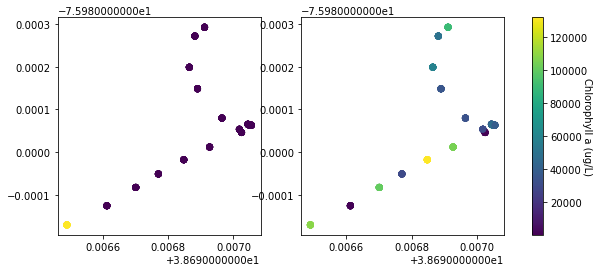

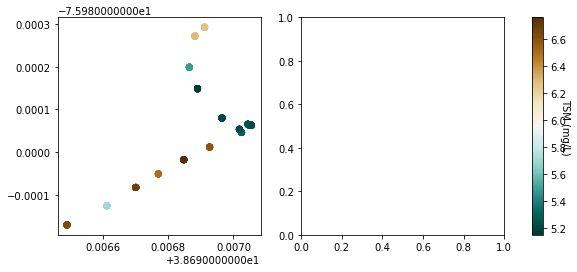

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(df)):  
    g = ax[0].scatter(df['    GPSLatitude'], df['    GPSLongitude'], c=df['chl_ocx'])
    ax[1].scatter(df['    GPSLatitude'], df['    GPSLongitude'], c=df['chl_gitelson'])
cbar = fig.colorbar(g, ax=ax)
cbar.set_label('Chlorophyll a (ug/L)', rotation=270)


fig1, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(df)):  
    g = ax[0].scatter(df['    GPSLatitude'], df['    GPSLongitude'], c=df['nechad_tsm'], cmap='BrBG_r')
cbar = fig.colorbar(g, ax=ax)
cbar.set_label('TSM (mg/L)', rotation=270)

### Georeferencing 


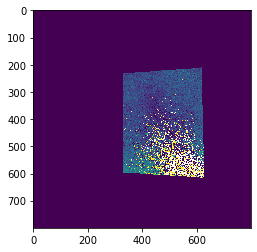

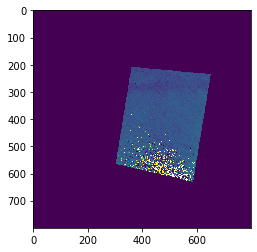

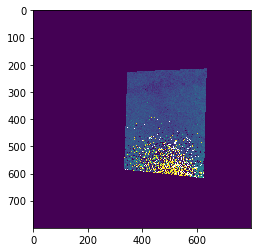

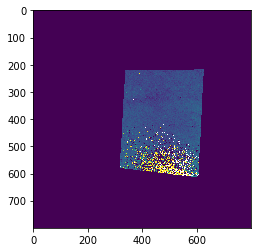

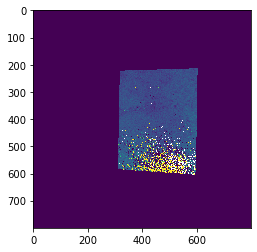

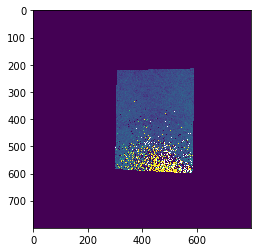

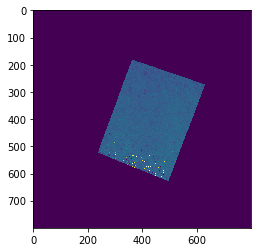

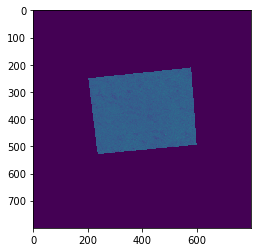

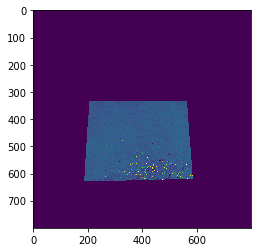

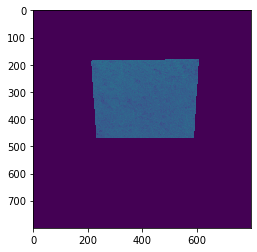

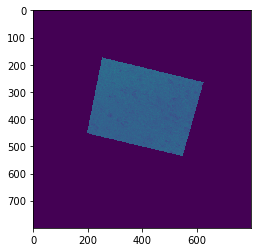

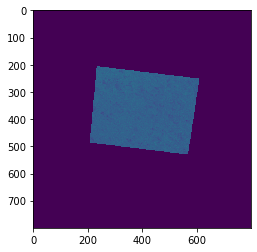

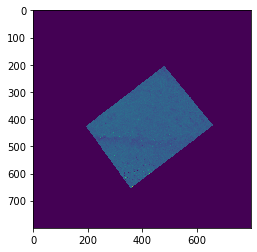

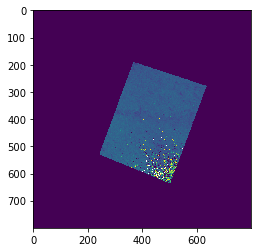

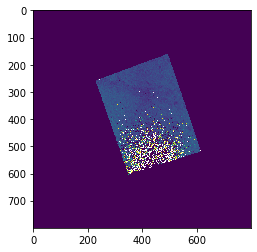

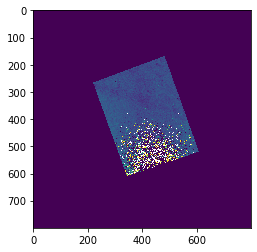

True

In [4]:
georeference(main_dir=project_path, img_dir=project_path+'/masked_rrs_hedley', output_dir_name='georeferenced_hedley_rrs', flip=True, plot=True)

#Would be nice to plot these as subplots to save room

(5, 1114, 1001)


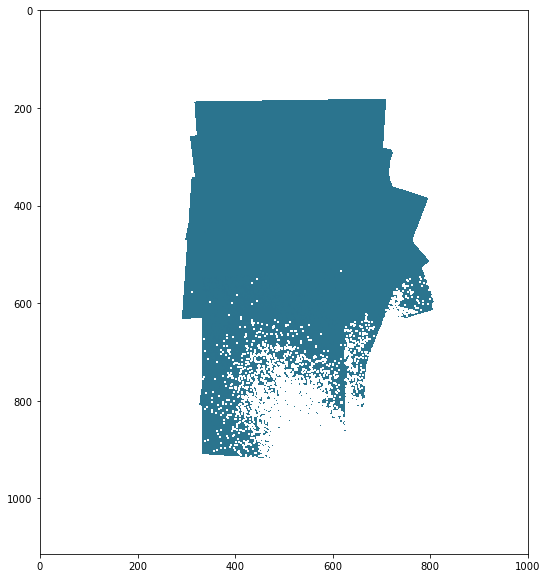

In [5]:
foo = mosaic(main_dir=project_path, img_dir = project_path+'/georeferenced_hedley_rrs', output_name='mosaic', plot=True, save=True, band_to_plot=0)
print(foo.shape)

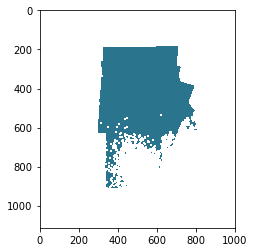

In [6]:
plt.imshow(foo[0,:,:])

#### Trying to figure out plotting points/.tifs over basemap

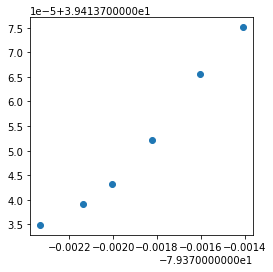

In [48]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(4, 4))

m = Basemap(projection='lcc', resolution='c',
            width=100000, height=100000, 
            lat_0=41, lon_0=-83, epsg=4326)

#m.etopo(scale=0.5, alpha=0.5)
plt.scatter(rrs_img_metadata['    GPSLongitude'], rrs_img_metadata['    GPSLatitude'])

plt.show()


In [38]:
rrs_imgs_hedley_masked, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')
rrs_img_metadata


SourceFile  \
filename                                                           
capture_1.tif  ../../../Broadford_Lake/0000SET/test/capture_1...   
capture_2.tif  ../../../Broadford_Lake/0000SET/test/capture_2...   
capture_3.tif  ../../../Broadford_Lake/0000SET/test/capture_3...   
capture_4.tif  ../../../Broadford_Lake/0000SET/test/capture_4...   
capture_5.tif  ../../../Broadford_Lake/0000SET/test/capture_5...   
capture_6.tif  ../../../Broadford_Lake/0000SET/test/capture_6...   

                  GPSDateStamp     GPSTimeStamp      GPSLatitude  \
filename                                                           
capture_1.tif       2022:09:09         14:31:26        39.413735   
capture_2.tif       2022:09:09         14:31:28        39.413739   
capture_3.tif       2022:09:09         14:31:29        39.413743   
capture_4.tif       2022:09:09         14:31:30        39.413752   
capture_5.tif       2022:09:09         14:31:32        39.413766   
capture_6.tif       2022:09:09         14:31:33        39.413775   

                  GPSLatitudeRef      GPSLongitude     GPSLongitudeRef  \
filename                                                                 
capture_1.tif                  N        -79.372333                   W   
capture_2.tif                  N        -79.372136                   W   
capture_3.tif                  N        -79.372006                   W   
capture_4.tif                  N        -79.371824                   W   
capture_5.tif                  N        -79.371603                   W   
capture_6.tif                  N        -79.371407                   W   

                   GPSAltitude      FocalLength      ImageWidth  ImageHeight  \
filename                                                                       
capture_1.tif          830.910          5.43432            1280          960   
capture_2.tif          831.069          5.43432            1280          960   
capture_3.tif          831.183          5.43432            1280          960   
capture_4.tif          831.106          5.43432            1280          960   
capture_5.tif          830.867          5.43432            1280          960   
capture_6.tif          830.749          5.43432            1280          960   

                   GPSImgDirection   GPSPitch    GPSRoll            UTC-Time  
filename                                                                      
capture_1.tif          -104.755043  10.051656 -10.353182 2022-12-09 14:31:26  
capture_2.tif          -102.999767   5.262329  -9.868161 2022-12-09 14:31:28  
capture_3.tif          -102.912107  12.716979  -9.874853 2022-12-09 14:31:29  
capture_4.tif          -102.934161  15.560780 -11.840869 2022-12-09 14:31:30  
capture_5.tif          -103.214419  12.266589 -16.332490 2022-12-09 14:31:32  
capture_6.tif          -102.863699  10.280256 -16.620142 2022-12-09 14:31:33

In [43]:
import geopandas

# Create point geometries
geometry = geopandas.points_from_xy(rrs_img_metadata['    GPSLongitude'], rrs_img_metadata['    GPSLatitude'])
geo_df = geopandas.GeoDataFrame(
    rrs_img_metadata, geometry=geometry
)

geo_df.head()

SourceFile  \
filename                                                           
capture_1.tif  ../../../Broadford_Lake/0000SET/test/capture_1...   
capture_2.tif  ../../../Broadford_Lake/0000SET/test/capture_2...   
capture_3.tif  ../../../Broadford_Lake/0000SET/test/capture_3...   
capture_4.tif  ../../../Broadford_Lake/0000SET/test/capture_4...   
capture_5.tif  ../../../Broadford_Lake/0000SET/test/capture_5...   

                  GPSDateStamp     GPSTimeStamp      GPSLatitude  \
filename                                                           
capture_1.tif       2022:09:09         14:31:26        39.413735   
capture_2.tif       2022:09:09         14:31:28        39.413739   
capture_3.tif       2022:09:09         14:31:29        39.413743   
capture_4.tif       2022:09:09         14:31:30        39.413752   
capture_5.tif       2022:09:09         14:31:32        39.413766   

                  GPSLatitudeRef      GPSLongitude     GPSLongitudeRef  \
filename                                                                 
capture_1.tif                  N        -79.372333                   W   
capture_2.tif                  N        -79.372136                   W   
capture_3.tif                  N        -79.372006                   W   
capture_4.tif                  N        -79.371824                   W   
capture_5.tif                  N        -79.371603                   W   

                   GPSAltitude      FocalLength      ImageWidth  ImageHeight  \
filename                                                                       
capture_1.tif          830.910          5.43432            1280          960   
capture_2.tif          831.069          5.43432            1280          960   
capture_3.tif          831.183          5.43432            1280          960   
capture_4.tif          831.106          5.43432            1280          960   
capture_5.tif          830.867          5.43432            1280          960   

                   GPSImgDirection   GPSPitch    GPSRoll            UTC-Time  \
filename                                                                       
capture_1.tif          -104.755043  10.051656 -10.353182 2022-12-09 14:31:26   
capture_2.tif          -102.999767   5.262329  -9.868161 2022-12-09 14:31:28   
capture_3.tif          -102.912107  12.716979  -9.874853 2022-12-09 14:31:29   
capture_4.tif          -102.934161  15.560780 -11.840869 2022-12-09 14:31:30   
capture_5.tif          -103.214419  12.266589 -16.332490 2022-12-09 14:31:32   

                                 geometry  
filename                                   
capture_1.tif  POINT (-79.37233 39.41373)  
capture_2.tif  POINT (-79.37214 39.41374)  
capture_3.tif  POINT (-79.37201 39.41374)  
capture_4.tif  POINT (-79.37182 39.41375)  
capture_5.tif  POINT (-79.37160 39.41377)


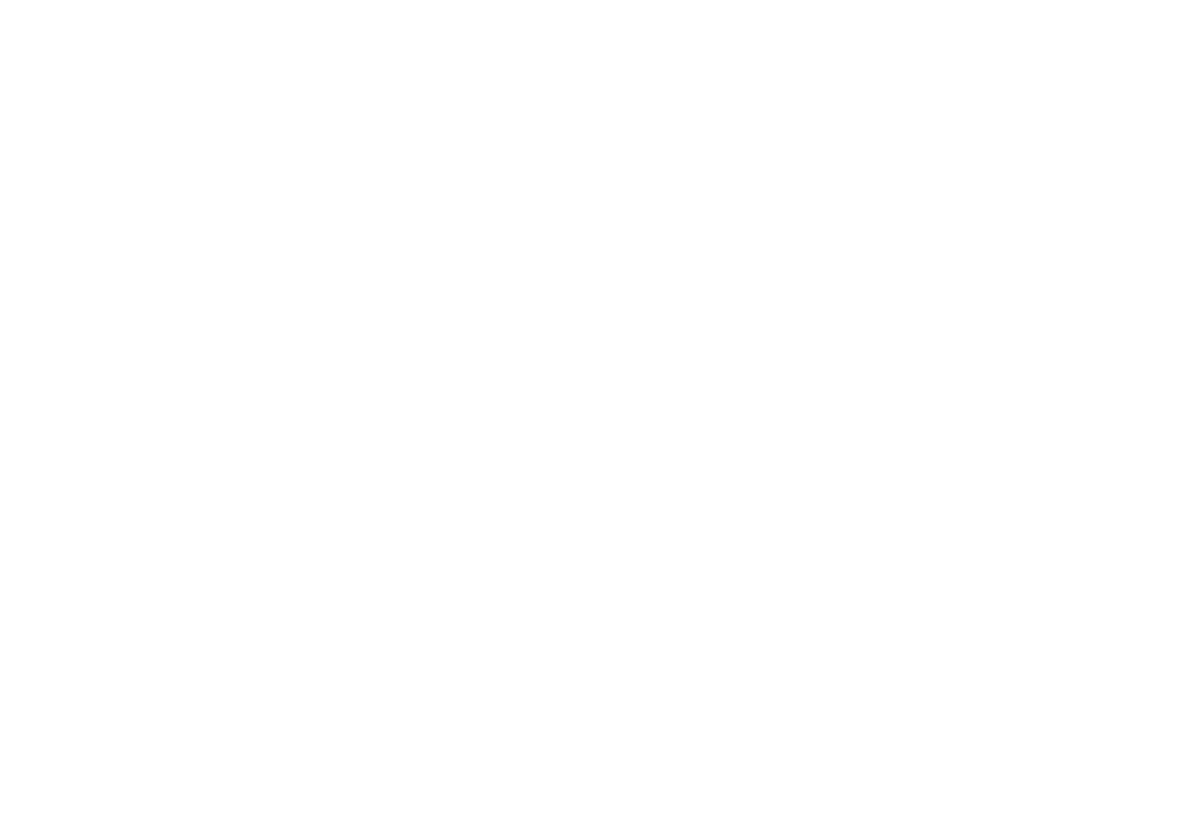

In [52]:
import folium

m = folium.Map(location=[39.4151, -79.3712], 
               tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
               attr= 'ESRI', zoom_start=15)


folium.raster_layers.ImageOverlay(
    image=foo[0,:,:],
    bounds=[[39, -79], [39, -79]],
    colormap=lambda x: (1, 0, 0, x),
).add_to(m)

m

AttributeError: 'Map' object has no attribute 'plot'

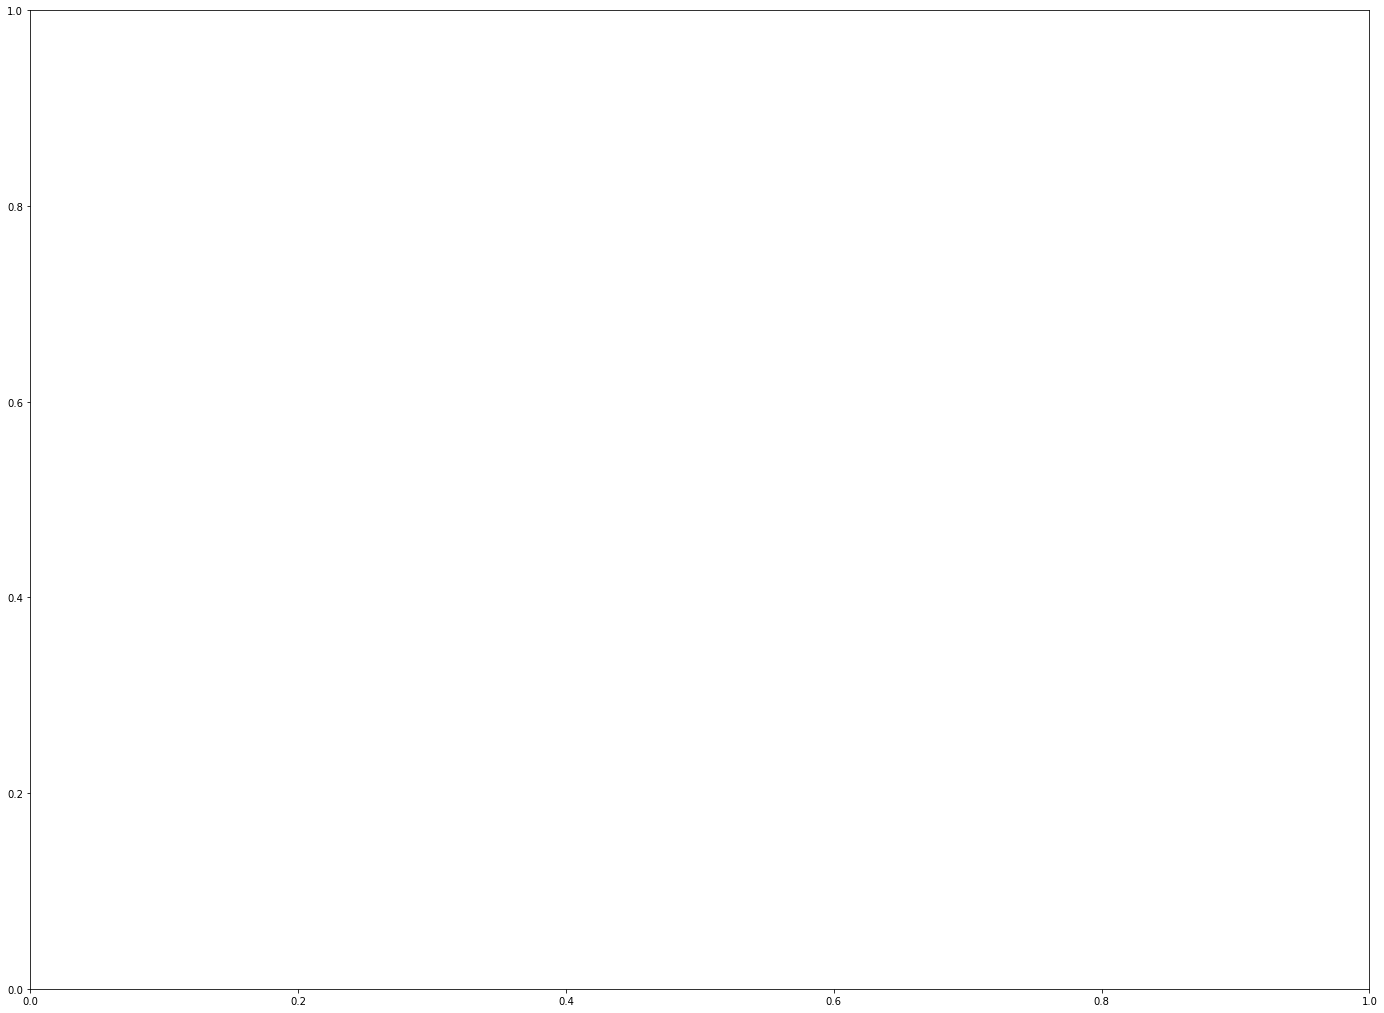

In [44]:
fig, ax = plt.subplots(figsize=(24, 18))
m.plot(ax=ax, alpha=0.4, color="grey")
geo_df.scatter(rrs_img_metadata.geometry, ax=ax, legend=True)
plt.title("Volcanoes")